# Potato Disease Classification

In [14]:
#import libaries
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 


In [89]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

In [16]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [17]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [33]:
len(dataset) 
#ans is 68 as batch size is 32 so it is like 68*32

68

In [22]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 0 0 1 2 0 0 1 0 1 2 0 1 1 1 1 1 1 0 1 2 1 0 0 0 1 0 0]


In [24]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


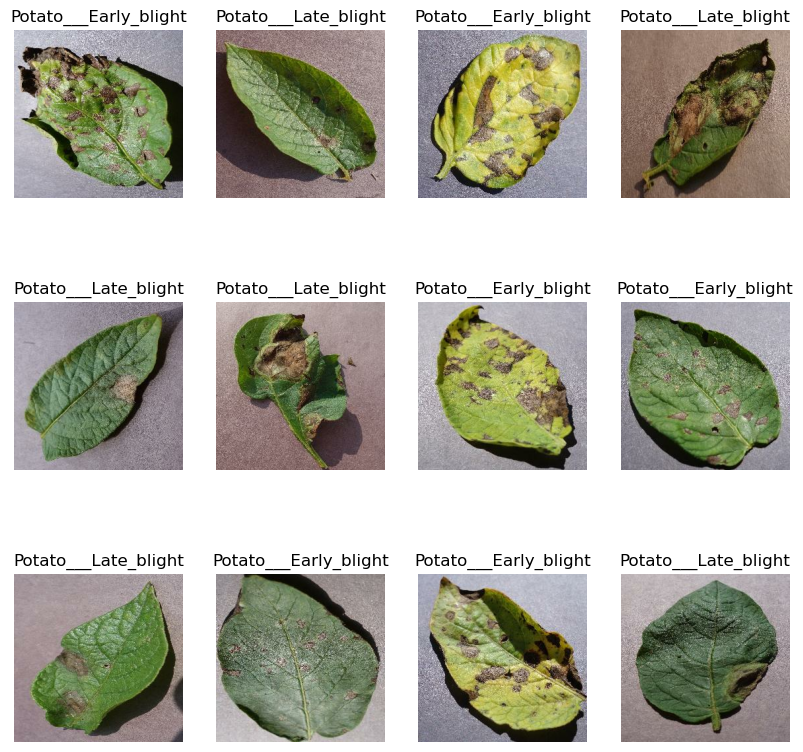

In [32]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [35]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [36]:
train_ds = dataset.take(54)
len(train_ds)

54

In [37]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [38]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [39]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [40]:
test_ds = test_ds.skip(6)
len(test_ds)

8

Lets wrap all above code in a function

In [41]:
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size  = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size  = int(val_split * ds_size)

    train_ds = ds.taken(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [42]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [43]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [44]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),

    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [45]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [46]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')


])
model.build(input_shape=input_shape)

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [48]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [90]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/25


54/54 [==============================] - 23s 429ms/step - loss: 0.0463 - accuracy: 0.9821 - val_loss: 0.1670 - val_accuracy: 0.9479
Epoch 2/25
54/54 [==============================] - 22s 399ms/step - loss: 0.0235 - accuracy: 0.9925 - val_loss: 0.0304 - val_accuracy: 0.9896
Epoch 3/25
54/54 [==============================] - 21s 396ms/step - loss: 0.0184 - accuracy: 0.9948 - val_loss: 0.0380 - val_accuracy: 0.9792
Epoch 4/25
54/54 [==============================] - 21s 396ms/step - loss: 0.0141 - accuracy: 0.9959 - val_loss: 0.1360 - val_accuracy: 0.9688
Epoch 5/25
54/54 [==============================] - 21s 395ms/step - loss: 0.0286 - accuracy: 0.9902 - val_loss: 0.0913 - val_accuracy: 0.9583
Epoch 6/25
54/54 [==============================] - 22s 399ms/step - loss: 0.0202 - accuracy: 0.9931 - val_loss: 0.0396 - val_accuracy: 0.9740
Epoch 7/25
54/54 [==============================] - 21s 396ms/step - loss: 0.0308 - accuracy: 0.9878 - val_loss: 0.3975 - val_accuracy: 0.8958
Epoch 8/25

In [91]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 98ms/step - loss: 0.2406 - accuracy: 0.9310


In [92]:
scores

[0.24062001705169678, 0.931034505367279]

In [93]:
history 

In [94]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [95]:
len(history.history['accuracy'])

25

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

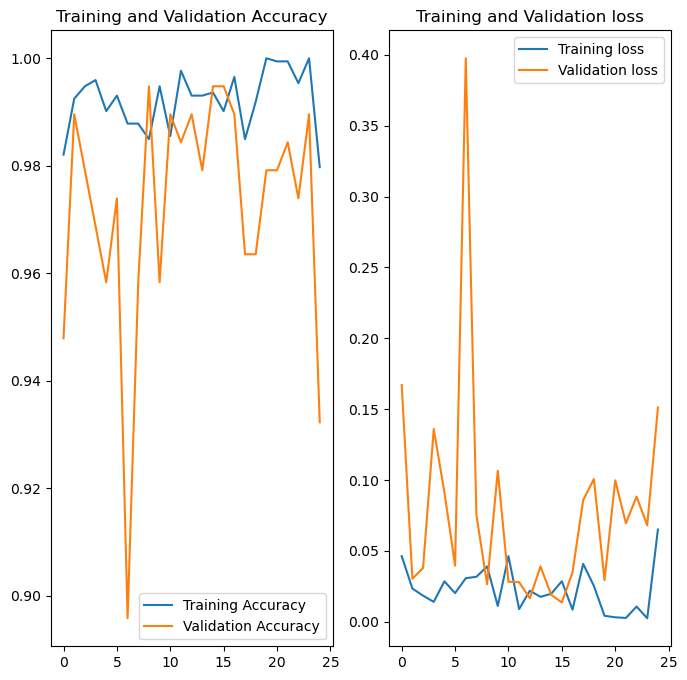

In [97]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = "Training loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation loss")
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')


In [98]:
import numpy as np

First Image to predict
first image's actual label :  Potato___Early_blight
1/1 [==============================] - 0s 127ms/step
Predicted label Potato___Early_blight


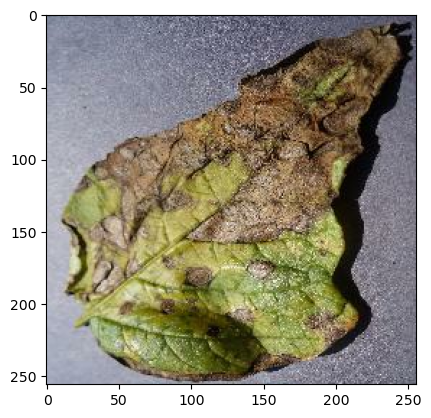

In [99]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("first image's actual label : ",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label",class_names[np.argmax(batch_prediction[0])])

In [100]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


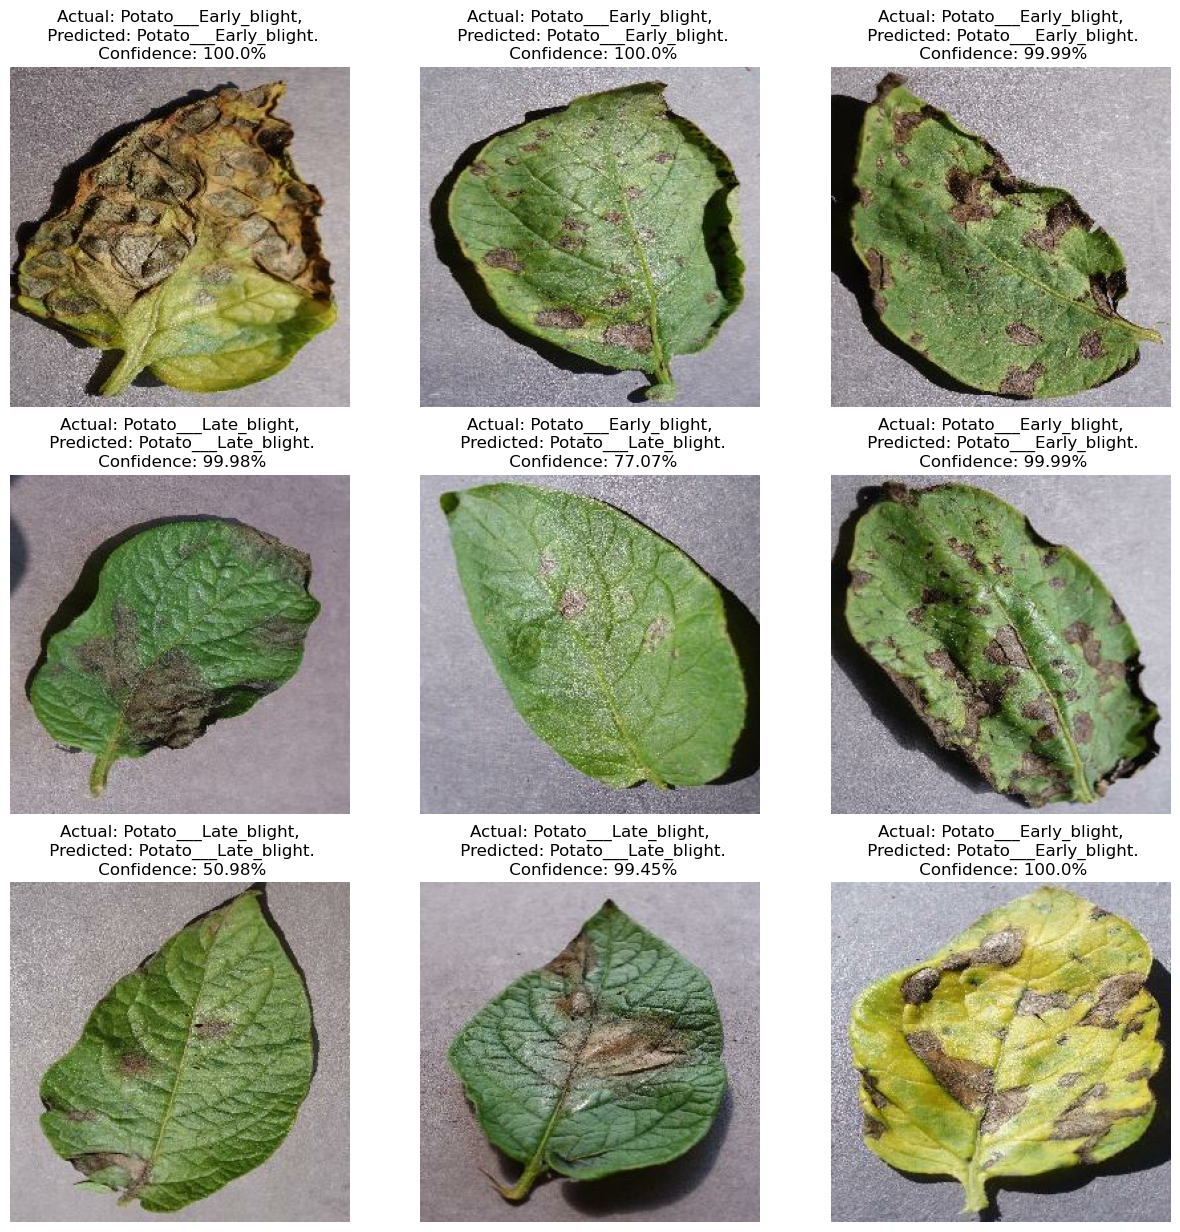

In [101]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [87]:
model_version = 1 
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [88]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")